# Guided Backprop Visualization

## Setup

In [251]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torchvision import transforms, models
from torchvision.models import EfficientNet_V2_S_Weights
from PIL import Image
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os
import csv


class TestDataset(Dataset):
    def __init__(self, csv_file, img_dir, transform=None):
        self.test_data = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.test_data)

    def __getitem__(self, idx):
        img_name = str(self.test_data.iloc[idx, 0])  # Assuming the image ID is in the first column
        img_path = os.path.join(self.img_dir, img_name)
        if not os.path.exists(img_path):
            img_path = os.path.join(self.img_dir, f"{img_name}.jpg")
        
        image = Image.open(img_path).convert('RGB')
        
        if self.transform:
            image = self.transform(image)

        return image, img_name


class StabilityPredictor(nn.Module):
    def __init__(self, num_classes=6):
        super(StabilityPredictor, self).__init__()
        weights = EfficientNet_V2_S_Weights.DEFAULT
        self.efficientnet = models.efficientnet_v2_s(weights=weights)
        num_ftrs = self.efficientnet.classifier[1].in_features
        self.efficientnet.classifier = nn.Sequential(
            nn.Dropout(p=0.3, inplace=True),
            nn.Linear(num_ftrs, num_classes)
        )

    def forward(self, x):
        return self.efficientnet(x)
    
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = StabilityPredictor(num_classes=6)
model.to(device)
model.load_state_dict(torch.load('stability_predictor_efficientnetv2_classification_augmented.pth', map_location=torch.device('cpu')))

def predict_single_image(model, image_tensor, device='cpu'):
    model.eval()
    
    # Move the input image to the appropriate device (CPU or GPU)
    image_tensor = image_tensor[0].to(device)
    
    # Disable gradient calculation for inference
    with torch.no_grad():
        # Forward pass through the model
        stability = model(image_tensor.unsqueeze(0))  # Add batch dimension
        
        # Get the predicted class index
        _, predicted = stability.max(1)
        
        # Add 1 to convert back to 1-6 range (assuming your classes are 1-indexed)
        prediction = predicted.item() + 1

    return prediction
def get_prediction_from_csv(img_tensor):
    id = img_tensor[1]
    # match id to corresponding value in 'predictions.csv'
    pred = predict_single_image(model, img_tensor, device='cpu')
    
    with open('./COMP90086_2024_Project_train/train.csv') as file:
        reader = csv.reader(file)
        for row in reader:
            if row[0] == id:
                gt = int(row[6])

    return pred, gt


# Custom ReLU to override the backward pass
class GuidedReLU(torch.autograd.Function):
    @staticmethod
    def forward(ctx, input):
        # Standard ReLU forward pass
        ctx.save_for_backward(input)
        return torch.clamp(input, min=0)

    @staticmethod
    def backward(ctx, grad_output):
        # Only pass positive gradients back
        input, = ctx.saved_tensors
        grad_input = grad_output.clone()
        grad_input[input <= 0] = 0
        grad_output[grad_output <= 0] = 0
        return grad_input

# Register hooks to replace ReLU activations in your model
def replace_relu_with_guided_relu(model):
    for name, module in model.named_modules():
        if isinstance(module, nn.ReLU):
            model._modules[name] = GuidedReLU.apply

def guided_backprop(model, input_image, target_class):
    # Set model to evaluation mode
    model.eval()

    # Enable gradient calculation on the input image
    input_image.requires_grad = True

    # Forward pass
    output = model(input_image)

    # Zero gradients
    model.zero_grad()

    # Get the score for the target class
    score = output[0, target_class]

    # Backward pass to compute the gradients
    score.backward()

    # Get the gradients from the input image
    gradients = input_image.grad.data

    return gradients

def visualize_guided_backprop(gradients, class_name, img_tensor):
    # Convert gradients to numpy array
    gradients = gradients.detach().cpu().numpy()[0]

    # Normalize the gradients to [0, 1]
    gradients = (gradients - gradients.min()) / (gradients.max() - gradients.min())

    # Set gradients to 0 where they aren't activated
    gradients[gradients < 0.2] = 0


    # Transofrm img_tensor into a displayable img_tensor_display
    img_tensor_display = img_tensor[0].clone()
    img_tensor_display = img_tensor_display.squeeze(0)
    img_tensor_display = img_tensor_display.permute(1, 2, 0)
    img_tensor_display = img_tensor_display.detach().cpu().numpy()
    img_tensor_display = (img_tensor_display - img_tensor_display.min()) / (img_tensor_display.max() - img_tensor_display.min())
    

    plt.figure(figsize=(15, 5))
    # Plot the gradients
    plt.subplot(1,3,1)
    plt.imshow(np.transpose(gradients, (1, 2, 0)))  # Convert from CHW to HWC format
    plt.axis('off')
    plt.title(f'Activations: Height={class_name+1}')

    plt.subplot(1,3,2)
    plt.imshow(img_tensor_display)
    plt.axis('off')
    plt.title('Original Image')
    
    plt.subplot(1,3,3)
    plt.imshow(img_tensor_display)
    plt.imshow(np.transpose(gradients, (1, 2, 0)), alpha=0.5)
    plt.axis('off')
    plt.title('Overlay')

    pred, gt = get_prediction_from_csv(img_tensor)

    plt.suptitle(f'Predicted Label: {pred}, Ground Truth: {gt}')

    plt.show()




def guided_backprop_viewer(model, img_tensor, see_all_classes=True):
    model.eval()
    replace_relu_with_guided_relu(model)

    pred, gt = get_prediction_from_csv(img_tensor)

    # Load and preprocess your input image (as a torch tensor)
    img = img_tensor[0].unsqueeze(0)

    img = img.clone().detach().requires_grad_(True)

    
    class_list = [1,2,3,4,5,6]

    if not see_all_classes:
        if pred == gt:
            class_list = [pred]
        else:
            class_list = [pred, gt]

    for target_class in class_list:
        gradients = guided_backprop(model, img, (target_class-1))  # remember to set target_class to zero-index here
        visualize_guided_backprop(gradients, (target_class-1), img_tensor)
# Load pre-calculated dataset statistics
stats = torch.load('dataset_stats.pth')
mean, std = stats['mean'], stats['std']

# Create transform for test set
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=mean.tolist(), std=std.tolist()),
])

# Create test dataset and dataloader
test_dataset = TestDataset(
    csv_file='./COMP90086_2024_Project_train/train.csv',
    img_dir='./COMP90086_2024_Project_train/train',
    transform=test_transform
)



## Run the cell below to test
##### `INDEX` will give you different images in the training set to try 

image id: 488852


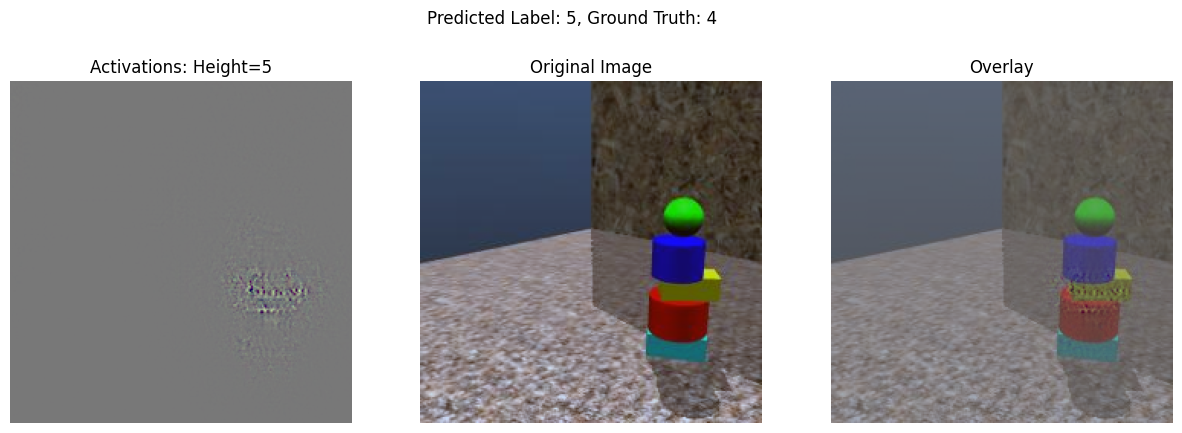

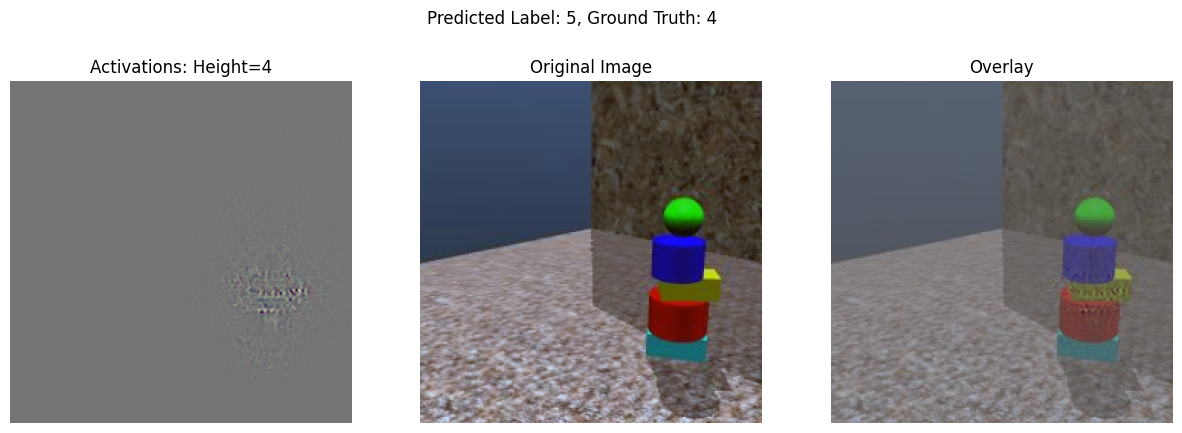

In [264]:
# Max index is 7680
INDEX = np.random.randint(0, 7680)

img_tensor = test_dataset[INDEX]

print(f'image id: {img_tensor[1]}')

# Set see_all_classes to True to see activation maps for every class, not just the ground truth and predicted class
guided_backprop_viewer(model, img_tensor, see_all_classes=False)  